# Latent Dirichlet Allocation

## Introduction

This notebook implements an LDA model for a corpus, about football, created with 12 articles from Wikipedia. The articles used are the following:
- https://en.wikipedia.org/wiki/Ballon_d%27Or 
- https://en.wikipedia.org/wiki/Barcelona
- https://en.wikipedia.org/wiki/UEFA_Champions_League
- https://en.wikipedia.org/wiki/FIFA 
- https://en.wikipedia.org/wiki/Football 
- https://en.wikipedia.org/wiki/Andr%C3%A9s_Iniesta  
- https://en.wikipedia.org/wiki/La_Liga  
- https://en.wikipedia.org/wiki/Lionel_Messi 
- https://en.wikipedia.org/wiki/Premier_League 
- https://en.wikipedia.org/wiki/Real_Madrid_CF 
- https://en.wikipedia.org/wiki/Cristiano_Ronaldo 
- https://en.wikipedia.org/wiki/FIFA_World_Cup


Note: The articles are used partially. 

## Reading and preprocessing the data

The cell bellow will read all the files which are present in './Docs' and will add them to a list. And this list will be basically the input.

The output is the name of the files read.

In [1]:
import os
import re
import nltk
from nltk.stem import PorterStemmer
import numpy as np
import matplotlib.pyplot as plt
fileContents = []
filePrefix = "./Docs/"
for r,d,f in os.walk(filePrefix):
    for file in f:
        print(file)
        content = open(filePrefix + file,"r")
        fileContents.append(content.read())
         

ballonDor.txt
barcelona.txt
championsleague.txt
fifa.txt
football.txt
iniesta.txt
laliga.txt
messi.txt
premierleague.txt
realmadrid.txt
ronaldo.txt
worldcup.txt


In [2]:
noFiles = len(fileContents)
print('Number of docs read %s'%noFiles)

Number of docs read 12


### Text preprocessing

In this section, we will apply some common preprocessing steps on the input to be able later to create a clean and relevant dictionary for our corpus.

This cell replaces all the characters in the initial input which are not letters with space.

In [3]:
        
charactersToBeReplaced = '[^a-zA-Z]+'
for i in range(len(fileContents)):
    fileContents[i]=re.sub(charactersToBeReplaced," ",fileContents[i])

This function will be used by the BuilderDictionary class later. Its purpose is to keep from the initial documents only the words which are nouns(with all the possible forms) and verb to the gerund.

In [4]:
def getTokens(corpus):
    tokensList = []
    for i in range(len(fileContents)):
        tokensList = tokensList+fileContents[i].split()
    aux = nltk.pos_tag(tokensList)
    return [token.lower() for (token,tag) in aux if tag[0]=='N' or tag=='VBG' ]

This function creates a dictionary with words and their frequencies, but it will take in consideration only the words which are in the list represented by the 3rd argument(this will be the list created by the above function) and it will ignore the ones which are in the 2nd argument(this will be the list of stopwords). Also, a second value will be returned by this function which will be the mean of the frequencies.

In [5]:
def getFrequenciesAndThreshold(corpus,ignoredWords,tokensList):
    stemmer = PorterStemmer()
    frequencies = {}
    for doc in fileContents:
        for word in doc.split():
            stemWord = stemmer.stem(word.lower())
            if stemWord not in ignoredWords and word.lower() not in ignoredWords and word.lower() in tokensList:
                if stemWord in frequencies:
                    frequencies[stemWord]+=1
                else:
                    frequencies[stemWord]=1
    sumFreq = 0
    for word in frequencies:
        sumFreq+=frequencies[word]
    threshold = sumFreq/(len(frequencies))
    return frequencies,threshold


The purpose of this class is to create the dictionary between words and the correspondent indexes in the corpus. It
will use the above functions and a list of stopwords for that. The function 'buildDictionary' will check every word in the corpus to see if: its stemmed/normal form is not in the stopwords list, the normal form is among the tokenList(nouns and verbs to the gerund) and the word's frequency is above or equal with the threshold(mean of the all the frequencies). If the word will match all the precedent criteria then it will be added in the dictionary and its initial form will be saved.

In [6]:
class DictionaryBuilder:
    def __init__(self,corpus):
        self.corpus=corpus
        self.ignoredWords=['a','a\'s','able','about','above','according','accordingly','across','actually','after','afterwards','put','again','against','ain\'t','ain','all','allow','allows','almost','alone','along','already','also','although','always','am','among','amongst','an','and','another','any','anybody','anyhow','anyone','anything','anyway','anyways','anywhere','apart','appear','appreciate','appropriate','are','aren','aren\'t','around','as','aside','ask','asking','associated','at','available','away','awfully','b','be','became','because','become','becomes','becoming','been','before','beforehand','behind','being','believe','below','beside','besides','best','better','between','beyond','both','brief','but','by','c','c\'mon','c\'s','came','can','can\'t','cannot','cant','cause','causes','certain','certainly','changes','clearly','co','com','come','comes','concerning','consequently','consider','considering','contain','containing','contains','corresponding','could','couldn','couldn\'t','course','currently','d','definitely','described','despite','doesn','pull','unlike','did','didn','didn\'t','different','do','does','doesn\'t','doing','don\'t','done','down','downwards','during','e','each','edu','eg','eight','either','else','elsewhere','enough','entirely','especially','et','etc','even','ever','every','everybody','everyone','everything','everywhere','ex','exactly','example','except','f','far','few','fifth','first','five','followed','following','follows','for','former','formerly','forth','four','from','further','furthermore','g','get','gets','getting','given','gives','go','goes','going','gone','got','gotten','greetings','h','had','hadn\'t','happens','hardly','has','hasn','hasn\'t','have','haven','haven\'t','having','he','he\'s','hello','help','hence','her','here','here\'s','hereafter','hereby','herein','hereupon','hers','herself','hi','him','himself','his','hither','hopefully','how','howbeit','however','i','i\'d','i\'ll','i\'m','i\'ve','ie','if','ignored','immediate','in','inasmuch','inc','indeed','indicate','indicated','indicates','inner','insofar','instead','into','inward','is','isn','isn\'t','it','it\'d','it\'ll','it\'s','its','itself','j','just','k','keep','keeps','kept','know','knows','known','l','last','lately','later','latter','latterly','least','less','lest','let','let\'s','like','liked','likely','little','look','looking','looks','ltd','m','mainly','many','may','maybe','me','mean','meanwhile','merely','might','more','moreover','most','mostly','much','must','my','myself','n','name','namely','nd','near','nearly','necessary','need','needs','neither','never','nevertheless','new','next','nine','no','nobody','non','none','noone','nor','normally','not','nothing','novel','now','nowhere','o','obviously','of','off','often','oh','ok','okay','old','on','once','one','ones','only','onto','or','other','others','otherwise','ought','our','ours','ourselves','out','outside','over','overall','own','p','particular','particularly','per','perhaps','placed','please','plus','possible','presumably','probably','provides','q','que','quite','qv','r','rather','rd','re','really','reasonably','regarding','regardless','regards','relatively','respectively','right','s','said','same','saw','say','saying','says','second','secondly','see','seeing','seem','seemed','seeming','seems','seen','self','selves','sensible','sent','serious','seriously','seven','several','shall','she','should','shouldn','shouldn\'t','since','six','so','some','somebody','somehow','someone','something','sometime','sometimes','somewhat','somewhere','soon','sorry','specified','specify','specifying','still','sub','such','sup','sure','true','false','t','t\'s','take','taken','tell','tends','th','than','thank','thanks','thanx','that','that\'s','thats','the','their','theirs','them','themselves','then','thence','there','there\'s','thereafter','thereby','therefore','therein','theres','thereupon','these','they','they\'d','they\'ll','they\'re','they\'ve','think','third','this','thorough','thoroughly','those','though','three','through','throughout','thru','thus','to','together','too','took','toward','towards','tried','tries','truly','try','trying','twice','two','u','un','under','unfortunately','unless','unlikely','until','unto','up','upon','us','use','used','useful','uses','using','usually','uucp','v','value','various','very','via','viz','vs','w','want','wants','was','wasn\'t','way','we','we\'d','we\'ll','we\'re','we\'ve','welcome','well','went','were','weren','weren\'t','what','what\'s','whatever','when','whence','whenever','where','where\'s','whereafter','whereas','whereby','wherein','whereupon','wherever','whether','which','while','whither','who','who\'s','whoever','whole','whom','whose','why','will','willing','wish','with','within','without','won\'t','wonder','would','would','wouldn','wouldn\'t','x','y','yes','yet','you','you\'d','man','ter','you\'ll','you\'re','you\'ve','your','mr','yours','mustn','yourself','yourselves','z','zero']
        self.tokensList = getTokens(corpus)
        self.frequencies,self.threshold = getFrequenciesAndThreshold(corpus,self.ignoredWords,self.tokensList)
    
    
    def buildDictionary(self):
        dictionary = {}
        initialWords = {}
        stemmer = PorterStemmer()
        newDocs = []
        for doc in self.corpus:
            auxDoc = []
            for word in doc.split():
                stemWord = stemmer.stem(word.lower())
                if stemWord not in self.ignoredWords and word.lower() not in self.ignoredWords and word.lower() in self.tokensList:
                    if self.frequencies[stemWord] >= int(self.threshold) :
                        if stemWord in dictionary and word not in initialWords[stemWord]:
                            initialWords[stemWord.lower()].append(word)
                        if stemWord not in self.ignoredWords and len(stemWord)>1:
                            if stemWord not in dictionary:
                                dictionary[stemWord]=len(dictionary)
                                initialWords[stemWord] = [word]
                            auxDoc.append(stemWord)  
            newDocs.append(auxDoc)
        # returns a dictionary for the stemmed words with their initial form, dictionary will be word:index pairs and newDocs
        # will be the corpus which contains only the words which passed the above filters
        return initialWords, dictionary,newDocs



Here we use the above class

In [7]:
dictionaryBuilder = DictionaryBuilder(fileContents)
origWord,dict,newDocs = dictionaryBuilder.buildDictionary()

## Building the model

Some initializations:
- beta = the parameter of the Dirichlet prior on the per-topic word distribution. Initialized with 1 because we want to start from a flat Dirichlet distribution.
- K = number of topics
- alpha = the parameter of the Dirichlet prior on the per-doc topic distribution. Initialized with 1 because we want to start from a flat Dirichlet distribution.
- M = number of docs
- N = vector of docs dimensions

In [8]:
beta=np.ones(len(dict))
K=5
alpha=np.ones(K)
M=noFiles
N=np.zeros(M,dtype=int)
for i,content in enumerate(newDocs):
    N[i]=len(content)

Here we replace the stemmed words from the corpus with the indexes saved in the dictionary

In [9]:
data = np.empty(M,dtype=object)
for i,doc in enumerate(newDocs):
    data[i] = np.empty(N[i],dtype=int)
    for j,word in enumerate(doc):
        data[i][j] = dict[word]


To implement LDA, we consider a document from the corpus to be a set of latent topics and each topic to be described by a distribution over the words. We model this with the following:
- theta[i] is a distribution over topics for the document i.
- phi[i] is a distribution over words for the topic i.
- z[i][j] is the topic of word j in the ith document. This value will be chosen with the help of a categorical random variable which has a probability parameter equal to theta[i].
- w[i][j] is the word j in document i. Its value is given by a categorical random variable which has a probability parameter equal to phi[z[i][j]].

phi is a list of length equal to the number of topics and its elements are probability distributions over vocabulary(arrays of numbers between 0 and 1 which sums to 1). So, phi[i].value[j] will be the probability of jth word from the vocabulary(keys of the dictionary) to be in the topic i.

In [10]:
import pymc

phi = np.empty(K, dtype=object)
auxPhi = np.empty(K, dtype=object)
for i in range(K):
    auxPhi[i]=pymc.Dirichlet("auxPhi_%s" % i,beta)
    phi[i]=pymc.CompletedDirichlet("phi_%s" % i,auxPhi[i])

Similar with phi, theta is a list of probability distributions, but this time the theta length is equal to the number of docs in the corpus and the lengths of the probability vectors are equal to the number of topics.

In [11]:
theta = np.empty(M, dtype=object)
auxTheta = np.empty(M, dtype=object)
for i in range(M):
    auxTheta[i]=pymc.Dirichlet("auxtheta_%s" % i,alpha)
    theta[i]=pymc.CompletedDirichlet("theta_%s" % i,auxTheta[i])

z is a list of random variables used to map between a word and a topic. So, z[i][j] is the topic of word j in the i-th document.
Theta[i] is used as a prior distribution for the probability vectors of the categoricals inside z[i].

In [12]:
z = []
for i in range(M):
    aux=[]
    for j in range(N[i]):
        aux.append(pymc.Categorical("z_%s_%s" %(i,j),p=theta[i]))
    z.append(pymc.Container(aux))

w[i][j] is the index of jth word in the ith document. These values are the only ones which are observed in the model.
For the probability parameter of the Categorical random variable, associated with each word in the corpus, we use as a prior the
Dirichlet distribution given by phi[z[i][j]] which means that we populate the probability parameter with the probability distribution over vocabulary of the topic saved in z[i][j]. To do this, we create a deterministic random variable with the help of Lambda from pymc.

In [13]:
w = []

for i in range(M):
    for j in range(N[i]):
        w.append(pymc.Categorical("w_%s_%s" %(i,j),p= pymc.Lambda('phi_z_%i_%i' % (i,j), 
                              lambda z=z[i][j], phi=phi: phi[z]),observed=True,value=data[i][j]))

Now we create the model using the random variables from above, but we add them in containers since they all are of an iterable type. And we ask for samples from the mcmc.


In [14]:
model = pymc.Model([pymc.Container(auxPhi),pymc.Container(auxTheta),pymc.Container(phi),pymc.Container(theta),pymc.Container(z),pymc.Container(w)])

mcmc = pymc.MCMC(model)
it=15000
burn=8000
dim=it-burn
mcmc.sample(it,burn)


C:\Users\Alin\Anaconda3\envs\pymc\lib\site-packages\pymc\MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 15000 of 15000 complete in 2515.2 sec

We save the trace for phi and theta

In [15]:
phi_samples = np.empty((K,dim,len(dict)))
for i in range(K):
    phi_samples[i] = mcmc.trace('phi_%i' % i)[:].reshape(dim,len(dict))

theta_samples=np.empty((M,dim,K))
for i in range(M):
    theta_samples[i] = mcmc.trace('theta_%i' % i)[:].reshape(dim,K)


Plots for the trace of the first theta(probability distribution over topics for the first doc)

Plotting theta_0_0_0
Plotting theta_0_0_1
Plotting theta_0_0_2
Plotting theta_0_0_3
Plotting theta_0_0_4


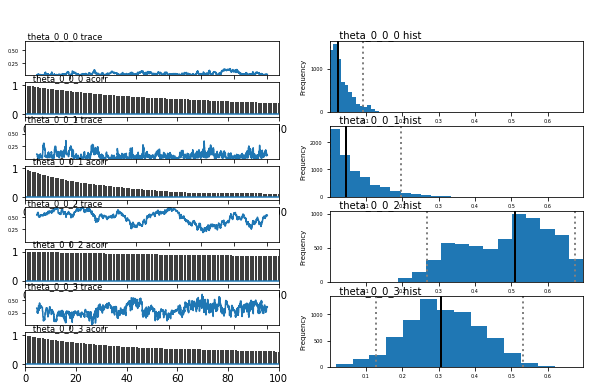

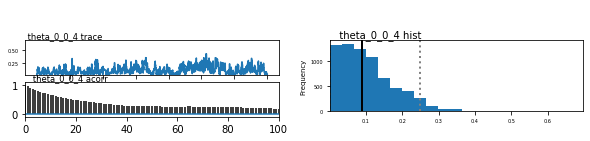

In [16]:
from pymc.Matplot import plot
plot(mcmc.trace('theta_0'))

## See the results

Here we compute the mean of the theta samples in order to obtain the probability distributions over topics for every doc.
We can see here for example that the last topic describes well the document about Messi and Barcelona(8 and 2).


In [17]:
theta_samples_mean = np.mean(theta_samples,axis=1)
print(theta_samples_mean)

[[0.03228509 0.06521626 0.48852804 0.31197981 0.10199079]
 [0.02636445 0.21266672 0.15385577 0.10586153 0.50125153]
 [0.03061394 0.36558253 0.04691269 0.31120267 0.24568818]
 [0.03047472 0.11396411 0.46897193 0.05574918 0.33084007]
 [0.04571738 0.07955232 0.66767355 0.0737314  0.13332535]
 [0.02692055 0.07350483 0.24005013 0.24071381 0.41881068]
 [0.15409217 0.09850875 0.62477699 0.04634643 0.07627567]
 [0.07391507 0.09073474 0.09208266 0.20697557 0.53629195]
 [0.18974723 0.45068842 0.06385968 0.08519882 0.21050585]
 [0.02592263 0.13692121 0.10720398 0.32246955 0.40748264]
 [0.01418332 0.27177255 0.14481259 0.48418613 0.08504541]
 [0.02658376 0.38770361 0.05902628 0.18062742 0.34605893]]


To get the first 20 most important words in every topic we use the mean of the phi samples and then we sort them.

In [18]:
countImportantWords = 20
valuesForPred = np.mean(phi_samples,axis=1)
mostImportantWords = np.empty((K,countImportantWords))
probabilityValues = np.empty((K,countImportantWords))
for i in range(K):
    mostImportantWords[i] = (np.argsort(valuesForPred[i])[len(dict)-countImportantWords:])[::-1]
    probabilityValues[i] = (np.sort(valuesForPred[i])[len(dict)-countImportantWords:])[::-1]

Top 20 words in each topic. 
The initial forms of words will be displayed.(the ones saved in origWord).
From these results we can see for example that the last topic is mainly about a football club and especially about Barcelona. And this explains the above theta values for the 2nd and 8th documents

If we want to describe the semantic value of every topic, we can say that:
- the first topic is about leagues of football, in our case only Premier League and La liga
- the second topic I think is more about competitions in general:Champions league, World Cups
- the 3rd topic is about football players and awards
- the 4th topic is about FIFA and the competitions organised by it:European and World Cups
- the last topic is about football clubs and tournaments

In [19]:
texts = []
aux=''
for i in range(K):
    print('topic_%i'%i)
    print('Probabilities:',probabilityValues[i])
    aux=''
    for value in mostImportantWords[i]:
        for word in dict:
            if dict[word]==value:
                print(origWord[word])
                aux = aux+ ' ' + ' '.join(origWord[word])
    texts.append(aux)

topic_0
Probabilities: [0.08608288 0.06676238 0.05690907 0.04219631 0.03682639 0.02960999
 0.02693988 0.02389167 0.02016313 0.01918237 0.01799585 0.01706893
 0.01644314 0.01632121 0.01627025 0.01586903 0.01531221 0.01488558
 0.01395675 0.01377449]
['League', 'league', 'leagues', 'Leagues']
['seasons', 'season', 'Seasons']
['Premier']
['Real', 'real']
['Cup', 'Cups']
['winning']
['sports', 'Sports', 'sporting', 'sport', 'Sporting']
['time', 'times']
['La', 'la']
['English']
['play', 'playing']
['teams', 'team', 'Team']
['games', 'game', 'Games']
['June']
['South']
['professional', 'Professional']
['rules']
['Europa']
['World', 'world']
['championship', 'championships', 'Championship']
topic_1
Probabilities: [0.06880931 0.05755685 0.050071   0.0481562  0.0328766  0.02469891
 0.02400084 0.02234921 0.02027761 0.02005795 0.01968956 0.01952264
 0.01853257 0.01832621 0.01816013 0.01812785 0.01628062 0.01587296
 0.01577581 0.01541224]
['World', 'world']
['titles', 'title']
['Champions', 'champ

Top 20 words as wordclouds

In [ ]:
from wordcloud import WordCloud
for i in range(K):
    wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="white").generate(texts[i])
    plt.figure()
    plt.title('Topic_%i'%i)
    plt.imshow(wordcloud)
    plt.show()

## Topic-based similarity measure between documents

To define a topic-based similarity measure between documents we can apply any similarity measure on the samples of theta.
For example, bellow is applied the cosine similarity, on the mean of the theta samples, to the docs about barcelona and messi and to the docs about barcelona and the ballon d'or award. And we can see that similarity for the first pair is bigger.(as expected)


In [20]:
product = np.dot(theta_samples_mean[1], theta_samples_mean[7])
norm_doc1 = np.linalg.norm(theta_samples_mean[1])
norm_doc7 = np.linalg.norm(theta_samples_mean[7])
cos_similarity = product / (norm_doc1 * norm_doc7)
print('Cosine similarity between doc_1 and doc_7:%f'%cos_similarity)
product = np.dot(theta_samples_mean[1], theta_samples_mean[0])
norm_doc1 = np.linalg.norm(theta_samples_mean[1])
norm_doc0 = np.linalg.norm(theta_samples_mean[0])
cos_similarity = product / (norm_doc1 * norm_doc0)
print('Cosine similarity between doc_1 and doc_0:%f'%cos_similarity)


Cosine similarity between doc_1 and doc_7:0.953114
Cosine similarity between doc_1 and doc_0:0.509270


## How to obtain the topic distribution for a new document?
- read the new file and keep only the words which are in our dictionary
- extend theta to contain a dirichlet distribution for the new document. Do the same with w and z.(categoricals for the words in the last document).
- initialize all the random variables with the values obtained before.
- set phi observed
- ask mcmc for fewer samples than before

In [22]:
filePrefix = "./test/"
test = ''
for r,d,f in os.walk(filePrefix):
    for file in f:
        print(file)
        content = open(filePrefix + file,"r")
        test = content.read()
        break
        
charactersToBeReplaced = '[^a-zA-Z]+'
test=re.sub(charactersToBeReplaced," ",test)
stemmer = PorterStemmer()
newDoc = [stemmer.stem(word.lower()) for word in test.split() if stemmer.stem(word.lower()) in dict ]
newDocs.append(newDoc)
N=np.zeros(M+1,dtype=int)
for i,content in enumerate(newDocs):
    N[i]=len(content)

xavi.txt


In [25]:
data = np.empty(M+1,dtype=object)
for i,doc in enumerate(newDocs):
    data[i] = np.empty(N[i],dtype=int)
    for j,word in enumerate(doc):
        data[i][j] = dict[word]

In [26]:
phi2 = np.empty(K, dtype=object)
auxPhi2 = np.empty(K, dtype=object)
beta = np.ones(len(dict))
for i in range(K):
    auxPhi2[i]=pymc.Dirichlet("auxPhi_%s" % i,beta,value=auxPhi[i].value,observed=True)
    phi2[i]=pymc.CompletedDirichlet("phi_%s" % i,auxPhi2[i])
theta2 = np.empty(M+1, dtype=object)
auxTheta2 = np.empty(M+1, dtype=object)
for i in range(M):
    auxTheta2[i]=pymc.Dirichlet("auxtheta_%s" % i,alpha,value=auxTheta[i].value)
    theta2[i]=pymc.CompletedDirichlet("theta_%s" % i,auxTheta2[i])
auxTheta2[M]=pymc.Dirichlet("auxtheta_%s" % M,alpha)
theta2[M]=pymc.CompletedDirichlet("theta_%s" % M,auxTheta2[M])

z2 = []
for i in range(M):
    aux=[]
    for j in range(N[i]):
        aux.append(pymc.Categorical("z_%s_%s" %(i,j),p=theta2[i]))
    z2.append(pymc.Container(aux))
aux=[]
for j in range(N[M]):
    aux.append(pymc.Categorical("z_%s_%s" %(M,j),p=theta2[M]))
z2.append(pymc.Container(aux))


w2 = []
for i in range(M):
    for j in range(N[i]):
        w2.append(pymc.Categorical("w_%s_%s" %(i,j),p= pymc.Lambda('phi_z_%i_%i' % (i,j), 
                              lambda z=z2[i][j], phi=phi2: phi[z].reshape(len(dict))),observed=True,value=data[i][j]))
for j in range(N[M]):
    w2.append(pymc.Categorical("w_%s_%s" %(M,j),p= pymc.Lambda('phi_z_%i_%i' % (M,j), 
                                  lambda z=z2[M][j], phi=phi2: phi[z].reshape(len(dict))),observed=True,value=data[M][j]))

In [29]:
model = pymc.Model([pymc.Container(auxTheta2),pymc.Container(auxPhi2),pymc.Container(phi2),pymc.Container(theta2),pymc.Container(z2),pymc.Container(w)])

mcmc = pymc.MCMC(model)
it=500
burn=300
dim=it-burn
mcmc.sample(it,burn)


 [-----------------100%-----------------] 500 of 500 complete in 64.4 sec

We see below that this new doc(which is about Xavi Hernandez,Barcelona and spanish player) is described best by the topic about  competitions in general:Champions league, World Cups(2nd)(Xavi is a winner of these competitions) and the one about football players and awards(3rd topic).

In [30]:
theta_samples2=np.empty((M+1,dim,K))
for i in range(M+1):
    theta_samples2[i] = mcmc.trace('theta_%i' % i)[:].reshape(dim,K)
theta_samples_mean2 = np.mean(theta_samples2,axis=1)
print(theta_samples_mean2[M])

[0.13877699 0.21365173 0.28945576 0.2413138  0.11680171]
